In [1]:
import os
import soundfile as sf
import numpy as np

inp_folder = 'audio_samples'
outp_folder = 'mixed_signals'
ica_folder = 'ica_samples'

In [2]:
file_names = ['speech.wav', 'street.wav', 'music.wav', 'white_noise.wav']

audio_speech, sr_speech = sf.read(os.path.join(inp_folder, file_names[0]))
audio_street, sr_street = sf.read(os.path.join(inp_folder, file_names[1]))
audio_music, sr_music = sf.read(os.path.join(inp_folder, file_names[2]))
audio_wnoise, sr_wnoise = sf.read(os.path.join(inp_folder, file_names[3]))

print("Array Type is: {}".format(audio_music.dtype))

audio_files = [audio_speech, audio_street, audio_music, audio_wnoise]
sample_rates = [sr_speech, sr_street, sr_music, sr_wnoise]
max_length = len(audio_files[0])

for name, sr, audio in zip(file_names, sample_rates, audio_files):
    print("File: {}, Sample Rate: {}, Samples: {}, Time: {}sec".format(name, sr, len(audio), len(audio)/sr))

Array Type is: float64
File: speech.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: street.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: music.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: white_noise.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec


In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

np.random.seed(10)

In [4]:
noise = np.random.normal(0, 1, len(audio_speech))

In [5]:
# 3 :                Music +                 Speech
d_sn_m_s_1 = 0.6 * audio_files[2] + 0.4 * audio_files[0] + audio_wnoise
d_sn_m_s_2 =  0.3 * audio_files[2] + 0.7 * audio_files[0] + audio_wnoise

true_signal = np.c_[audio_files[0], audio_files[2]]

In [6]:
# d_sn_m_s_1 *= noise
# d_sn_m_s_2 *= noise
# d_sn_m_s_3 *= noise

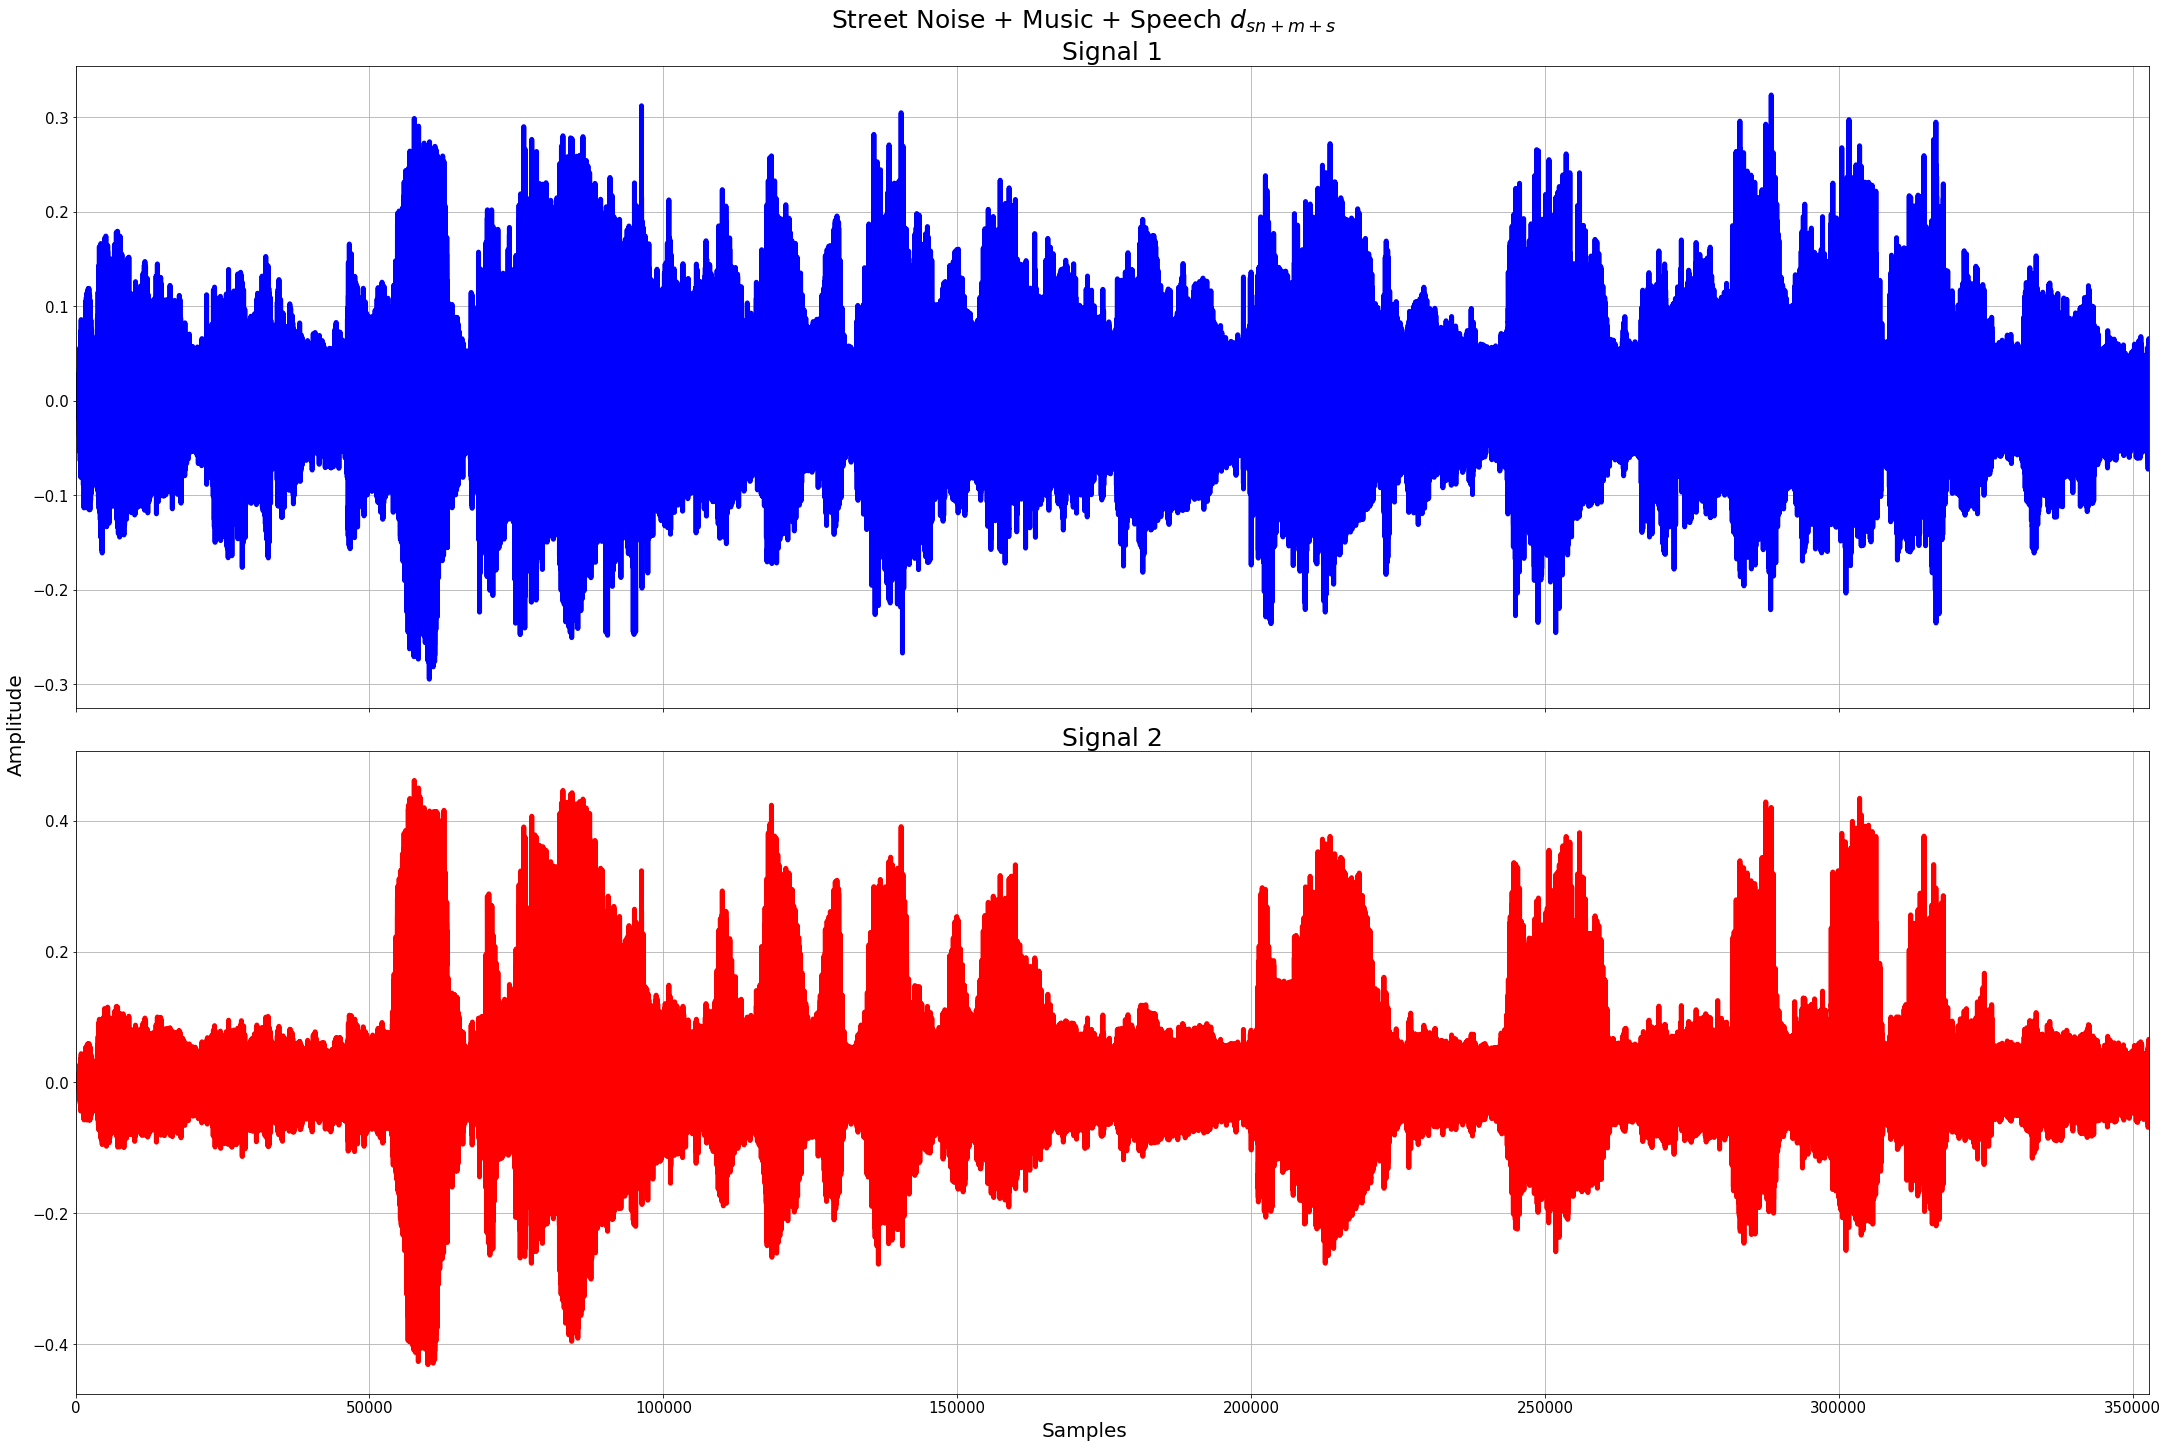

In [7]:
fig, axs = plt.subplots(2, 1, figsize=[30, 20], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)
fig.supxlabel('Samples', fontsize=20)
fig.suptitle('Street Noise + Music + Speech $d_{sn+m+s}$', fontsize=25)

axs[0].plot(d_sn_m_s_1, lw=5, color='blue')
axs[0].set_title('Signal 1', fontsize=25)
axs[1].plot(d_sn_m_s_2, lw=5, color='red')
axs[1].set_title('Signal 2', fontsize=25)


for ax in axs: 
    ax.set_xlim(0, max_length)
    ax.tick_params(labelsize=15)
    ax.grid()

In [8]:
observation = np.c_[d_sn_m_s_1, d_sn_m_s_2]

observation /= observation.std(axis=0)

In [9]:
ica = FastICA()
ica_recovered = ica.fit_transform(observation) 
print(ica_recovered.shape)

(352800, 2)


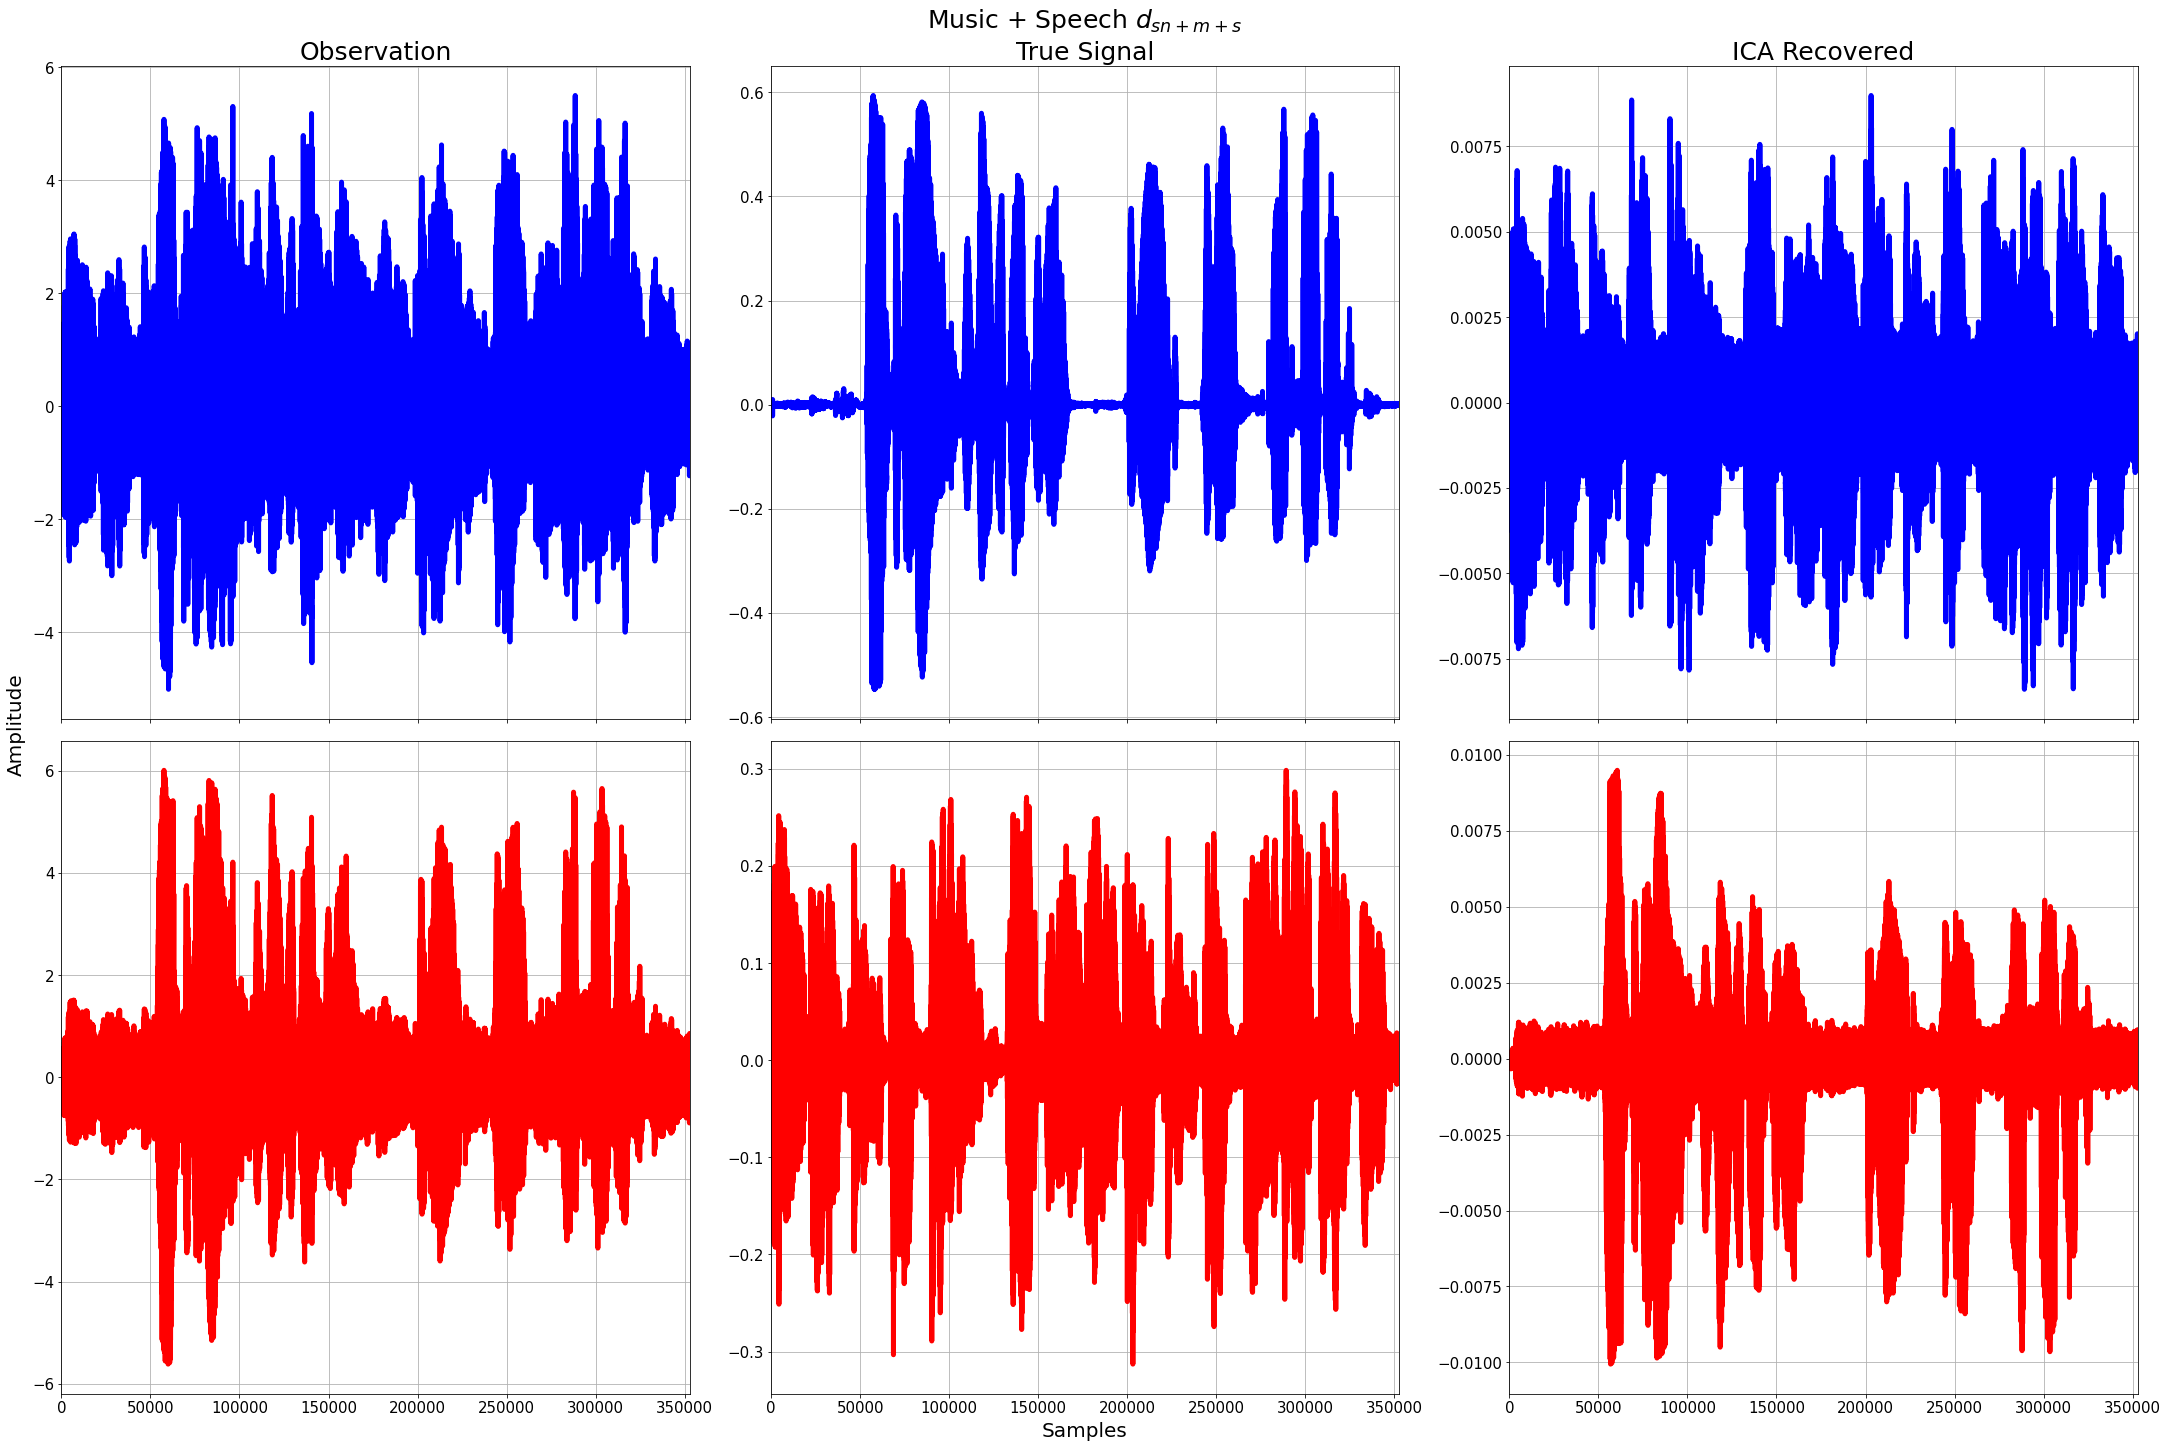

In [10]:
simple_plot = False
if simple_plot:
    fig, axs = plt.subplots(2, 1, figsize=[30, 20], sharex=True, constrained_layout = True)
    fig.supylabel('Amplitude', fontsize=20)
    fig.supxlabel('Samples', fontsize=20)
    fig.suptitle('Street Noise + Music + Speech $d_{sn+m+s}$', fontsize=25)
    
    axs[0].plot(ica_recovered[:, 0], lw=5, color='blue')
    axs[0].set_title('ICA Recovered', fontsize=25)
    axs[1].plot(ica_recovered[:, 1], lw=5, color='red')
    # axs[2].plot(ica_recovered[:, 2], lw=5, color='black')

    for ax in axs: 
        ax.set_xlim(0, max_length)
        ax.tick_params(labelsize=15)
        ax.grid()
else:
    ica_lst = [observation, true_signal, ica_recovered]
    ica_name = ['Observation', 'True Signal', 'ICA Recovered']
    fig, axs = plt.subplots(2, 3, figsize=[30, 20], sharex=True, constrained_layout = True)
    fig.supylabel('Amplitude', fontsize=20)
    fig.supxlabel('Samples', fontsize=20)
    fig.suptitle('Music + Speech $d_{sn+m+s}$', fontsize=25)

    for ii, (data, name) in enumerate(zip(ica_lst, ica_name)):
        axs[0][ii].plot(data[:, 0], lw=5, color='blue')
        axs[0][ii].set_title(name, fontsize=25)
        axs[1][ii].plot(data[:, 1], lw=5, color='red')
        # axs[2][ii].plot(data[:, 2], lw=5, color='black')

    for row in axs: 
        for ax in row: 
            ax.set_xlim(0, max_length)
            ax.tick_params(labelsize=15)
            ax.grid()

In [11]:
import pywt

In [12]:
wavelet = 'db3'
mode = 'sym'

In [13]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d), axis)

In [22]:
def sqtwolog_criterion(coeffs): 
    # Sqtwolog Criterion
    coeff_thres = []
    for coeff in coeffs:
        sigma = (1/0.6745) * madev(coeffs[-1])
        threshold = sigma * np.sqrt(2 * np.log(max_length))
        coeff_thres.append(pywt.threshold(coeff, value=threshold, mode='hard'))
    return coeff_thres

In [23]:
def denoise(signal, wavelet, mode, plot_wavelets=False):
    coeffs = pywt.wavedec(signal, wavelet, mode=mode)
    cA = coeffs[0]
    cD = coeffs[1:]
    if plot_wavelets:
        fig, axs = plt.subplots(len(coeffs)+1, 1, figsize=[18, 30], sharex=True, constrained_layout = True)
        fig.supylabel('Amplitude', fontsize=20)

        axs[0].plot(ica_recovered[:, 0], lw=5)
        axs[0].set_title('Mixed Data', fontsize=25)

        for ii, coeff in enumerate(coeffs):
            axs[ii+1].plot(coeff, lw=5)
            axs[ii+1].set_title('c'+ str(ii), fontsize=25)

        axs[len(coeffs)].set_xlabel('Samples', fontsize=20)

        for ax in axs:
            ax.set_xlim(0)
            ax.tick_params(labelsize=15)
            ax.grid()

    cD_thres = sqtwolog_criterion(cD)       

    coeff_denoised = [cA]
    for ii in cD_thres:
        coeff_denoised.append(ii)

    return pywt.waverec(coeff_denoised , wavelet, mode=mode)



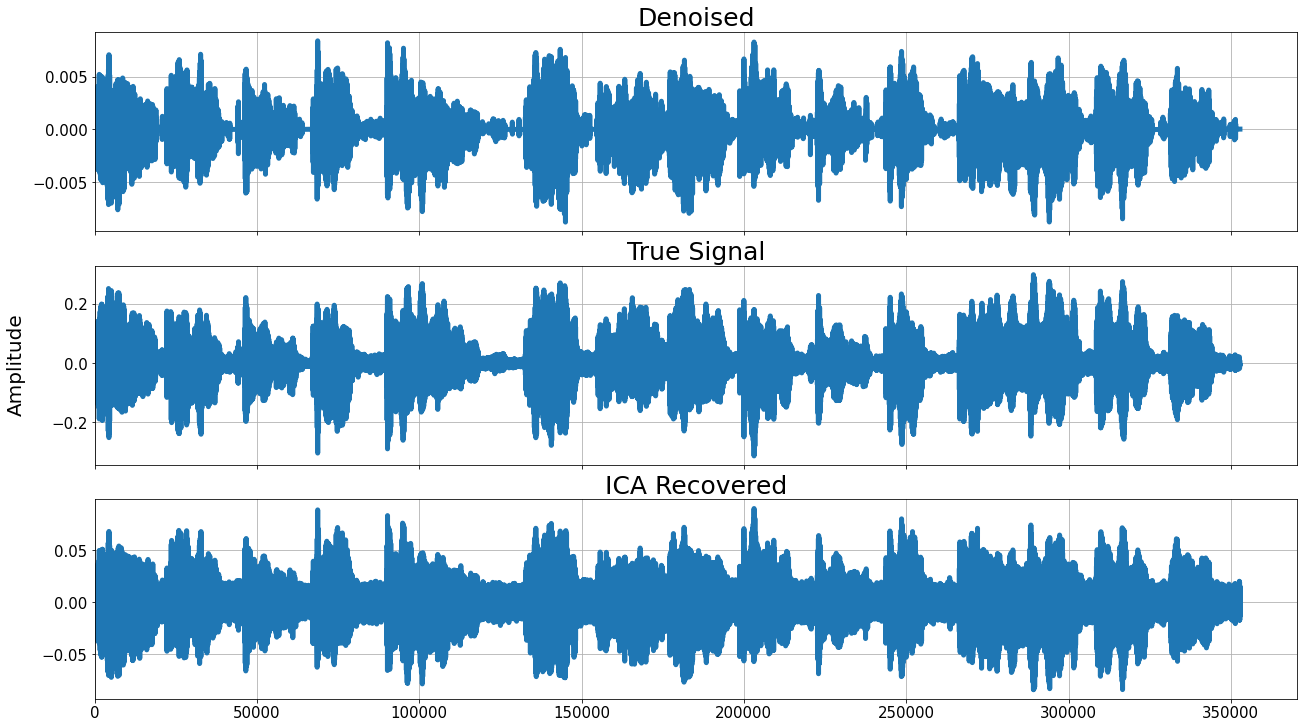

In [25]:
filtered = denoise(ica_recovered[:, 0], wavelet, mode)

fig, axs = plt.subplots(3, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)

axs[0].plot(filtered, lw=5)
axs[0].set_title('Denoised', fontsize=25)

axs[1].plot(true_signal[:, 1], lw=5)
axs[1].set_title('True Signal', fontsize=25)

axs[2].plot(ica_recovered[:, 0] * 10, lw=5)
axs[2].set_title('ICA Recovered', fontsize=25)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

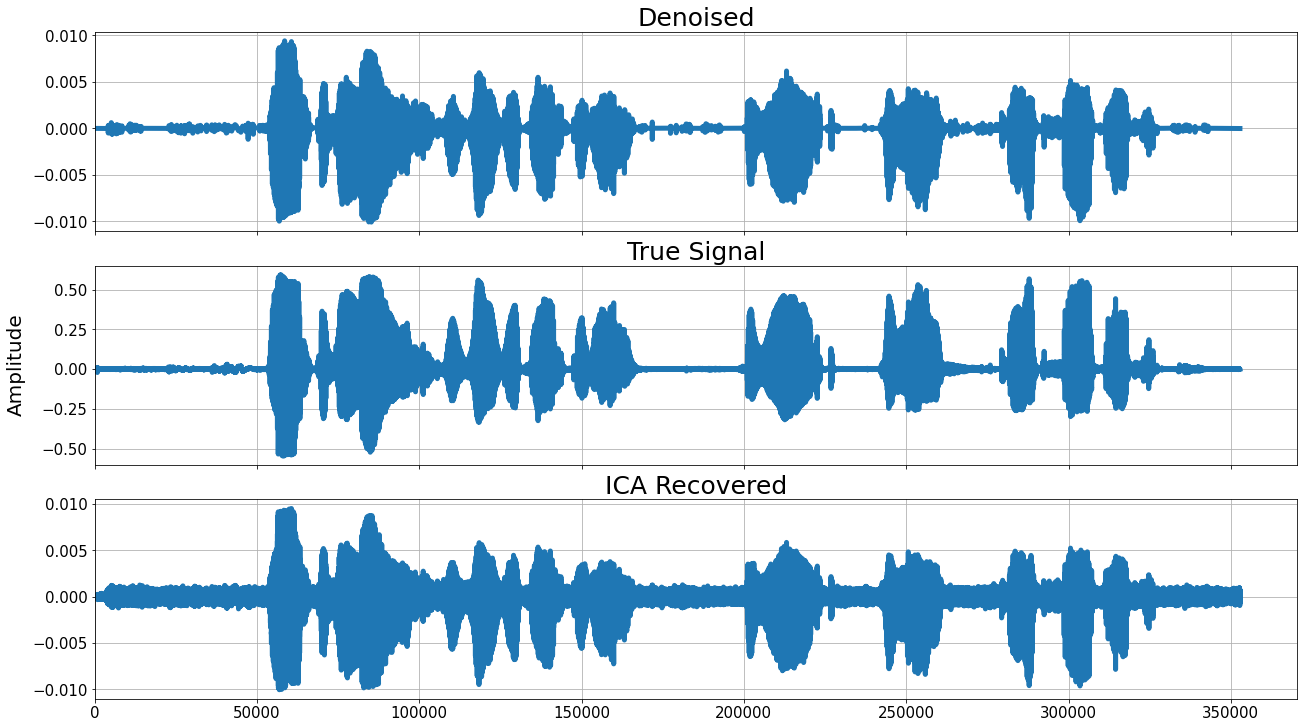

In [ ]:
filtered = denoise(ica_recovered[:, 1], wavelet, mode)

fig, axs = plt.subplots(3, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)

axs[0].plot(filtered, lw=5)
# axs[0].plot(true_signal[:, 0] - filtered, lw=5)
axs[0].set_title('Denoised', fontsize=25)

axs[1].plot(true_signal[:, 0], lw=5)
axs[1].set_title('True Signal', fontsize=25)

axs[2].plot(ica_recovered[:, 1], lw=5)
axs[2].set_title('ICA Recovered', fontsize=25)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()



In [ ]:
# filtered = denoise(ica_recovered[:, 0], wavelet, mode)

# fig, axs = plt.subplots(3, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
# fig.supylabel('Amplitude', fontsize=20)

# axs[0].plot(filtered, lw=5)
# axs[0].set_title('Denoised', fontsize=25)

# axs[1].plot(true_signal[:, 1], lw=5)
# axs[1].set_title('True Signal', fontsize=25)

# axs[2].plot(ica_recovered[:, 0], lw=5)
# axs[2].set_title('ICA Recovered', fontsize=25)

# for ax in axs:
#     ax.set_xlim(0)
#     ax.tick_params(labelsize=15)
#     ax.grid()

In [ ]:
def signaltonoise(a, axis=0, ddof=0):
    """
    https://github.com/scipy/scipy/blob/v0.16.0/scipy/stats/stats.py#L1963
    
    The signal-to-noise ratio of the input data.
    Returns the signal-to-noise ratio of `a`, here defined as the mean
    divided by the standard deviation.
    Parameters
    ----------
    a : array_like
        An array_like object containing the sample data.
    axis : int or None, optional
        Axis along which to operate. Default is 0. If None, compute over
        the whole array `a`.
    ddof : int, optional
        Degrees of freedom correction for standard deviation. Default is 0.
    Returns
    -------
    s2n : ndarray
        The mean to standard deviation ratio(s) along `axis`, or 0 where the
        standard deviation is 0.
    """
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [ ]:
def signaltonoise_dB(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20*np.log10(abs(np.where(sd == 0, 0, m/sd)))